In [1]:
import transformers
#!pip install torchtext
import torch, torchtext
import torch.nn.functional as F
import torch.nn as nn

In [2]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
#!pip install torcheval
#from torcheval.metrics.functional import multiclass_f1_score
from transformers import BertTokenizer, BertModel, AutoModel, AutoProcessor
from tqdm import tqdm

In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-xrays-indiana-university:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F516716%2F951996%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240313%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240313T194535Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D56a9bf406e6788783fc03ac303250e28df99991ab8b3ba22abd48435a17c22606283dc102cb86ad449b3fd8a864a5d03f04db92fc29faaadcfbe23eb963600fa50f089909a43b956fbb113a2393e64c4dbd49d23e98b0458508986a1d08b2bcd391a7cffc01a79f3ef66606d328c4de7926447ee684da3aefbd5c06875414f5067e4a600f00824d14487a82f64fae14876073c9361802eb0d2276a280af12acb1a2433be3b4d4c8e097b222015b6ba772cc217f6beb4614432793312d185222889017aab197a743dd684720dc2eb74cbbcdefcd7669f94e94511b65aeb45300ade35e8bdf8d24c40a6c630a3619b0bb9ab1e69fa39cfaffa87a92294190326a8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


Системе не удается найти указанный путь.


OSError: [WinError 1314] Клиент не обладает требуемыми правами: '/kaggle/input' -> '..\\input'

In [4]:
batch_size = 4
num_epochs = 25
#image_size = 256
image_size = 224

# Import Libaries

In [5]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torch
import torch.optim as optim
import itertools
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
%pwd

'C:\\Users\\rozal\\Documents\\Diploma'

In [7]:
df2 = pd.read_csv('D:\\IndianaReports\\indiana_projections.csv')
df1 = pd.read_csv('D:\\IndianaReports\\indiana_reports.csv')
df1.loc[df1['Problems'].str.contains('Lung'),'Problems']='Lung'
df1 = df1.loc[df1['Problems'].isin(['Lung','normal'])]
df1 = df1[:20]
len(df1)

20

In [8]:
images_captions_df = pd.DataFrame({'image': [],
                                    'caption': [],'number_of_words':[],'problem':[]})
for i in range(len(df2)):
    uid = df2.iloc[i]['uid']
    image = df2.iloc[i]['filename']
    index = df1.loc[df1['uid'] ==uid]

    if not index.empty:
        index = index.index[0]
        caption = df1.loc[index]['findings']
        problem = df1.loc[index]['Problems']
        number_of_words = len(str(caption).split())

        if type(caption) == float:
                continue
        images_captions_df = pd.concat([images_captions_df, pd.DataFrame([{'image': image, 'caption': caption ,'number_of_words':number_of_words,'problem':problem}])], ignore_index=True)

images_captions_df["number_of_words"] =  images_captions_df["caption"].apply(lambda text: len(str(text).split()))
images_captions_df['number_of_words'] = images_captions_df['number_of_words'].astype(int)

print(images_captions_df.head())

                       image  \
0     1_IM-0001-4001.dcm.png   
1     1_IM-0001-3001.dcm.png   
2  5_IM-2117-1003002.dcm.png   
3  5_IM-2117-1004003.dcm.png   
4     6_IM-2192-1001.dcm.png   

                                             caption  number_of_words problem  
0  The cardiac silhouette and mediastinum size ar...               34  normal  
1  The cardiac silhouette and mediastinum size ar...               34  normal  
2  The cardiomediastinal silhouette and pulmonary...               42    Lung  
3  The cardiomediastinal silhouette and pulmonary...               42    Lung  
4  Heart size and mediastinal contour are within ...               32  normal  


In [9]:
from sklearn.model_selection import train_test_split

image_folder = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'
image_filenames = images_captions_df.image.values

# image_filenames = image_filenames[0:100]

train_captions,test_val_captions =train_test_split(images_captions_df, test_size = 0.2)
test_captions, val_captions =train_test_split(test_val_captions, test_size = 0.2)

print(train_captions.head())
print(len(train_captions),len(test_captions),len(val_captions))

                        image  \
31    34_IM-1644-2001.dcm.png   
3   5_IM-2117-1004003.dcm.png   
35    36_IM-1776-2001.dcm.png   
4      6_IM-2192-1001.dcm.png   
6      8_IM-2333-1001.dcm.png   

                                              caption  number_of_words problem  
31  The heart is normal in size and contour. The l...               22  normal  
3   The cardiomediastinal silhouette and pulmonary...               42    Lung  
35  The lungs are clear bilaterally. Specifically,...               30  normal  
4   Heart size and mediastinal contour are within ...               32  normal  
6   The heart, pulmonary XXXX and mediastinum are ...               38  normal  
28 6 2


In [25]:
train_captions

,image,caption,number_of_words,problem
328,365_IM-1812-1002.dcm.png,The lungs are clear. The cardiomediastinal sil...,16,normal
165,195_IM-0618-1001.dcm.png,Clear lungs bilaterally. No pneumothorax or pl...,11,normal
74,84_IM-2363-2001.dcm.png,There are low lung volumes with bronchovascula...,29,Lung
36,38_IM-1911-1001.dcm.png,Lungs are clear. There is no pneumothorax or p...,22,normal
199,238_IM-0939-2001.dcm.png,Stable cardiomediastinal silhouette. No focal ...,15,normal
...,...,...,...,...
253,297_IM-1361-2001.dcm.png,Cardiac silhouette is within normal limits in ...,73,Lung
266,307_IM-1432-1001.dcm.png,The cardiomediastinal silhouette and pulmonary...,24,normal
324,363_IM-1798-2001.dcm.png,Normal cardiomediastinal contours. No focal co...,11,normal
144,164_IM-0419-2001.dcm.png,The Cardiopulmonary silhouette is normal. The ...,20,normal


(224, 224, 3)


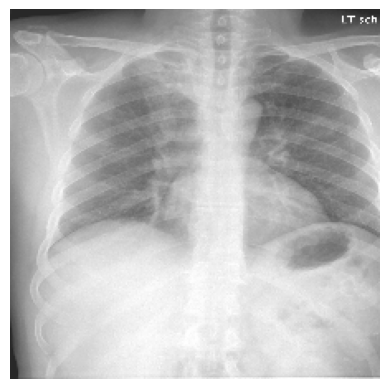

In [10]:
# test , not important
def image_preprocessing(image_path,target_size):
   # Load the image using PIL
    img = cv2.imread(image_path)
    # Resize the image using PIL's resize method
    img = cv2.resize(img,(target_size,target_size), )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def display_image(image_array):
    # Display the image using matplotlib
    plt.imshow(image_array)
    plt.axis('off')  # Turn off axis labels
    plt.show()
image = image_preprocessing("E:/LangsImgDatasetForDiploma/images_normalized/1000_IM-0003-1001.dcm.png",image_size)
print(image.shape)
display_image(image)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

"""
For the Argumentative Component Classification (ACC) task, we need to remove the 'O' label from the dataset.
"""
MODEL_NUM_LABELS = 3
REMOVE_OTHER = True
OTHER_LABEL = 'O'

if REMOVE_OTHER:
    MODEL_NUM_LABELS = 2

TEXT_MODEL_CARD = 'bert-base-uncased'
AUDIO_MODEL_CARD = 'facebook/wav2vec2-base-960h'

LABEL_2_ID = {
    'normal': 0,
    'Lung': 1
}

ID_2_LABEL = {
    0: 'normal',
    1: 'Lung'
}


EMBEDDING_DIM = 768
BATCH_SIZE = 12

Using device: cpu


In [12]:
import os
# Get the number of available processors
num_processors = os.cpu_count()

# Example dataset class
class ImageTextDataset(Dataset):
    def __init__(self, image_filenames, captions, problems, image_size=256):
        self.image_filenames = image_filenames
        self.captions = captions
        self.problems = problems
        self.transform = transforms.Compose([
                                                 # Resize images to a consistent size
                                                #transforms.ToTensor(),
                                                transforms.ToTensor(),          # Convert images to tensors
                                                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
                                            ])


    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image_path = "E:/LangsImgDatasetForDiploma/images_normalized/"+image_filenames[index]

        image = image_preprocessing(image_path,image_size ) #
        image = list(np.array(self.transform(image)))#.permute(2,1,0)
        text = self.captions[index]
        problem = LABEL_2_ID[self.problems[index]]

        return image, text, problem

# Create an instance of the dataset

train_dataset = ImageTextDataset(train_captions.image.values, train_captions.caption.values, train_captions.problem.values, image_size)
test_dataset = ImageTextDataset(test_captions.image.values, test_captions.caption.values, test_captions.problem.values, image_size)
val_dataset = ImageTextDataset(val_captions.image.values, val_captions.caption.values, val_captions.problem.values, image_size)

In [20]:
np.shape(train_dataset[0][0])

(3, 256, 256)

In [24]:
train_dataset[0][0].shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
batch_size, num_channels, height, width

In [37]:
next(iter(train_dataloader))[1]

[tensor([[[0.5843, 0.5451, 0.5098,  ..., 0.2157, 0.0235, 0.0235],
          [0.5725, 0.5412, 0.4863,  ..., 0.1686, 0.0235, 0.0235],
          [0.5529, 0.5255, 0.4667,  ..., 0.1686, 0.0235, 0.0235],
          ...,
          [0.0549, 0.0549, 0.0549,  ..., 0.0667, 0.0667, 0.0667],
          [0.0549, 0.0549, 0.0549,  ..., 0.0667, 0.0667, 0.0667],
          [0.0549, 0.0549, 0.0549,  ..., 0.0667, 0.0667, 0.0667]],
 
         [[0.5843, 0.5451, 0.5098,  ..., 0.2157, 0.0235, 0.0235],
          [0.5725, 0.5412, 0.4863,  ..., 0.1686, 0.0235, 0.0235],
          [0.5529, 0.5255, 0.4667,  ..., 0.1686, 0.0235, 0.0235],
          ...,
          [0.0549, 0.0549, 0.0549,  ..., 0.0667, 0.0667, 0.0667],
          [0.0549, 0.0549, 0.0549,  ..., 0.0667, 0.0667, 0.0667],
          [0.0549, 0.0549, 0.0549,  ..., 0.0667, 0.0667, 0.0667]],
 
         [[0.5843, 0.5451, 0.5098,  ..., 0.2157, 0.0235, 0.0235],
          [0.5725, 0.5412, 0.4863,  ..., 0.1686, 0.0235, 0.0235],
          [0.5529, 0.5255, 0.4667,  ...,

In [133]:
next(iter(train_dataloader))[1][0].shape

torch.Size([3, 256, 256])

In [19]:
print(train_dataset. __getitem__(0)[0].shape)

torch.Size([3, 256, 256])


In [13]:
def create_dataloader(dataset, batch_size):
    """
    Create a DataLoader object from the given dataset with the given batch size
    Args:
        dataset: dataset to use
        batch_size: batch size to use
    """
    def pack_fn(batch):
        """
        Function to pad the audio features and create the attention mask
        """
        #print('batch\r\n',batch)
        texts = [x[1] for x in batch]
        ''''for x in batch:
            print(type(x[0]),x[0].shape)
            print('x[0]\r\n',x[0])'''
        audio_features = [x[0] for x in batch]
        labels = torch.tensor([x[2] for x in batch])
        return texts, audio_features, labels

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pack_fn)
    return dataloader

In [61]:
# Create a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True ) # , prefetch_factor=num_processors, num_workers=1, pin_memory=True, drop_last=True
test_dataloader = DataLoader(test_dataset, batch_size=batch_size*16, shuffle=False ) # , prefetch_factor=num_processors, num_workers=1, pin_memory=True, drop_last=False
val_dataloader = DataLoader(val_dataset, batch_size=batch_size*16, shuffle=False )

In [14]:
# Этот вариант
train_dataloader = create_dataloader(train_dataset, batch_size)
val_dataloader = create_dataloader(val_dataset, batch_size)
test_dataloader = create_dataloader(test_dataset, batch_size)

In [63]:
next(iter(train_dataloader))

(['Low lung volumes are present. The heart size and pulmonary vascularity appear within normal limits. No pleural effusion or pneumothorax is seen. Scattered XXXX of left base atelectasis are noted. Left XXXX-a-XXXX is in XXXX with the tip projecting over the caval atrial junction.',
  'The lungs are clear. Heart and pulmonary XXXX appear normal. The pleural spaces are clear and mediastinal contours are normal. Nodular density overlying the anterior left 4th rib XXXX represents a healing rib fracture.',
  'Lungs are overall hyperexpanded with flattening of the diaphragms. No focal consolidation. No pleural effusions or pneumothoraces. Heart and mediastinum of normal size and contour. Degenerative changes in the thoracic spine.',
  'The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. The patient was shielded.'],
 [[array([[0.14117648, 0.13333334, 0.12941177, ..., 0.1

# Display Few Image with Caption

In [23]:
# Fetch a batch from the dataloader
batch_texts, batch_images,  batch_problems = next(iter(train_dataloader))

for index in range(batch_images[0].shape[0]):
    # Fetch the image and text for the chosen index
    image_to_display = batch_images[index]
    text_to_display = batch_texts[index]
    problem_to_display = batch_problems[index]

    # Display the problem
    print("Problem:", problem_to_display, "\n\n\n")

    # Convert the image tensor to a NumPy array
    image_to_display_np = image_to_display.permute(1, 2, 0).numpy()

    # Display the image using matplotlib
    plt.imshow(image_to_display_np)
    plt.axis('off')  # Turn off axis labels
    plt.show()

    # Display the corresponding text
    print("Caption:", text_to_display, "\n\n\n")
    if index>=5:
        break

AttributeError: 'list' object has no attribute 'shape'

# # Create a DataLoader

In [30]:
class TextModel(nn.Module):
    """
    Class for the text-only model
    """
    def __init__(self, tokenizer, embedder, head):
        """
        Args:
            tokenizer: tokenizer to use
            embedder: embedder to use
            head: head to use
        """
        super().__init__()
        self.tokenizer = tokenizer
        self.embedder = embedder
        self.head = head
    def forward(self, texts, audio_features):
        """, audio_attention
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        tokenizer_output = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=False).to(device)
        embedder_output = self.embedder(**tokenizer_output, output_hidden_states=True)
        text_features = embedder_output['last_hidden_state']

        # pooling transformer output
        text_features_sum = (text_features * tokenizer_output.attention_mask.unsqueeze(-1)).sum(axis=1)
        text_features_pooled = text_features_sum / tokenizer_output.attention_mask.sum(axis=1).unsqueeze(-1)

        print(text_features_pooled.shape)
        return self.head(text_features_pooled)

In [33]:
head_hidden_dimension=224
text_only_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
text_only = TextModel(tokenizer, embedder, text_only_head)

In [35]:
b = next(iter(train_dataloader))
texts = b[0]
pixel_values = b[1]
text_only.forward(texts, pixel_values)

torch.Size([4, 768])


tensor([[ 0.0445, -0.0980],
        [ 0.0568, -0.1147],
        [ 0.0574, -0.1358],
        [ 0.0811, -0.1310]], grad_fn=<AddmmBackward0>)

In [15]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput

In [16]:
class ViTForImageClassification(nn.Module):
    def __init__(self, head, num_labels=MODEL_NUM_LABELS):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels
        self.head = head
    def forward(self, texts, pixel_values):
        #print('texts',texts)
        #print('pixel_values',pixel_values)
        #batch_size, num_channels, height, width
        outputs = self.vit(pixel_values=torch.tensor(pixel_values))
        output = self.dropout(outputs.last_hidden_state[:,0])
        print(output.shape)
        return self.head(output)

In [33]:
head_hidden_dimension=224
img_only_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
img_only = ViTForImageClassification(img_only_head)

In [34]:
#b = next(iter(train_dataloader))
texts = b[0]
pixel_values = b[1]
img_only.forward(texts, pixel_values)

torch.Size([4, 768])


tensor([[0.0658, 0.0547],
        [0.0406, 0.0611],
        [0.0568, 0.0786],
        [0.0784, 0.0706]], grad_fn=<AddmmBackward0>)

In [17]:
class ImageModel(nn.Module):
    """
    Class for the text-only model
    """
    def __init__(self, tokenizer, embedder, head):
        """
        Args:
            tokenizer: tokenizer to use
            head: head to use
        """
        super().__init__()
        self.tokenizer = tokenizer
        self.embedder = embedder
        self.head = head
    def forward(self, texts, audio_features):
        """, audio_attention
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        tokenizer_output = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=False).to(device)
        embedder_output = self.embedder(**tokenizer_output, output_hidden_states=True)
        text_features = embedder_output['last_hidden_state']

        # pooling transformer output
        text_features_sum = (text_features * tokenizer_output.attention_mask.unsqueeze(-1)).sum(axis=1)
        text_features_pooled = text_features_sum / tokenizer_output.attention_mask.sum(axis=1).unsqueeze(-1)
        return self.head(text_features_pooled)

In [39]:
def create_models(
        head_hidden_dimension=224, dropout_prob=0.1, hidden_state_index=8,   # shared parameters head_hidden_dimension=256
        audioonly_nheads=8, audioonly_d_ffn=100, audioonly_n_layers=1, # audio only parameters
        csa_nheads=4, csa_d_ffn=2048, csa_n_layers=1, # multimodal parameters
        ensembling_nheads=4, ensembling_d_ffn=2048, ensembling_n_layers=1, # ensembling parameters
        multa_nblocks=4, multa_d_ffn=2048 # unaligned parameters
    ):
    """
    Helper function to create and return all the models
    """
    ###################################################################################### -- TEXT MODEL --
    """text_only_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    text_only = TextModel(tokenizer, embedder, text_only_head)"""

    ###################################################################################### -- IMAGE MODEL --
    img_only_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    img_only = ViTForImageClassification(img_only_head)
    #image_only = models.get('vit_base', num_classes = 2, pretrained_weights='imagenet')
    """image_size_only_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    image_only = TextModel(tokenizer, embedder, image_only_head)"""

    ###################################################################################### -- MULTIMODAL MODEL --
    """multimodal_encoder = CustomEncoder(d_model=EMBEDDING_DIM, ffn_hidden=csa_d_ffn, n_head=csa_nheads, n_layers=csa_n_layers, drop_prob=dropout_prob)
    multimodal_transformer_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    multimodal_transformer = CSA(tokenizer, embedder, multimodal_encoder, multimodal_transformer_head, hidden_state_index=hidden_state_index).to(device)"""


    ###################################################################################### -- ENSEMBLING MODEL --
    """ensembling_text_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    ensembling_audio_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    ensembling_transformer_layer = nn.TransformerEncoderLayer(d_model=EMBEDDING_DIM, nhead=ensembling_nheads, dim_feedforward=ensembling_d_ffn, batch_first=True).to(device)
    ensembling_transformer_encoder = nn.TransformerEncoder(ensembling_transformer_layer, num_layers=ensembling_n_layers).to(device)
    ensembling_text_model = TextModel(tokenizer, embedder, ensembling_text_head)
    ensembling_audio_model = AudioModel(ensembling_transformer_encoder, ensembling_audio_head)
    ensembling_fusion = Ensembling(ensembling_text_model, ensembling_audio_model).to(device)"""


    ###################################################################################### -- UNALIGNED MODEL --
    """unaligned_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM*2, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    unaligned_mm_model = MulTA(embedding_dim=EMBEDDING_DIM, d_ffn=multa_d_ffn, n_blocks=multa_nblocks, head=unaligned_head, hidden_state_index=hidden_state_index, dropout_prob=dropout_prob).to(device)
    """

    ###################################################################################### -- RETURN --
    """model_names = ['Image-Only', 'Text-Only']
    models = [img_only, text_only]"""
    """model_names = ['Text-Only']
    models = [text_only]"""
    model_names = ['img_only']
    models = [img_only]
    return model_names, models

In [19]:
# set up tokenizer and model
tokenizer = BertTokenizer.from_pretrained(TEXT_MODEL_CARD)
embedder = BertModel.from_pretrained(TEXT_MODEL_CARD).to(device)

# freeze bert layers
for params in embedder.parameters():
    params.requires_grad = False

# Downsample audio features to 1/5 of the original size to fit in memory
DOWNSAMPLE_FACTOR = 1/5

'''class MM_Dataset(torch.utils.data.Dataset):
    """
    Dataset class for multimodal dataset
    """
    def __init__(self, df, audio_dir, sample_rate):
        """
        Args:
            df: dataframe containing the dataset
            audio_dir: directory containing the audio clips
            sample_rate: sample rate to use for audio clips
        """
        self.audio_dir = audio_dir
        self.sample_rate = sample_rate

        self.audio_processor = AutoProcessor.from_pretrained(AUDIO_MODEL_CARD)
        self.audio_model = AutoModel.from_pretrained(AUDIO_MODEL_CARD).to(device)

        self.dataset = []

        # Iterate over df
        for _, row in tqdm(df.iterrows()):
            path = os.path.join(self.audio_dir, f"{row['Document']}/{row['idClip']}.wav")
            if os.path.exists(path):
                # obtain audio WAV2VEC features
                audio, sampling_rate = torchaudio.load(path)
                # resample audio if necessary
                if sampling_rate != self.sample_rate:
                    audio = torchaudio.functional.resample(audio, sample_rate, self.sample_rate)
                    # mean pooling over channels
                    audio = torch.mean(audio, dim=0, keepdim=True)
                with torch.inference_mode():
                    # run audio through model
                    input_values = self.audio_processor(audio, sampling_rate=self.sample_rate).input_values[0]
                    input_values = torch.tensor(input_values).to(device)
                    audio_model_output = self.audio_model(input_values)
                    audio_features = audio_model_output.last_hidden_state[0].unsqueeze(0)
                    # downsample audio features
                    audio_features = torch.nn.functional.interpolate(audio_features.permute(0,2,1), scale_factor=DOWNSAMPLE_FACTOR, mode='linear')
                    audio_features = audio_features.permute(0,2,1)[0]
                    audio_features = audio_features.cpu()

                text = row['Text']

                self.dataset.append((text, audio_features, LABEL_2_ID[row['Component']]))
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return self.dataset[index]'''

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'class MM_Dataset(torch.utils.data.Dataset):\n    """\n    Dataset class for multimodal dataset\n    """\n    def __init__(self, df, audio_dir, sample_rate):\n        """\n        Args:\n            df: dataframe containing the dataset\n            audio_dir: directory containing the audio clips\n            sample_rate: sample rate to use for audio clips\n        """\n        self.audio_dir = audio_dir\n        self.sample_rate = sample_rate\n\n        self.audio_processor = AutoProcessor.from_pretrained(AUDIO_MODEL_CARD)\n        self.audio_model = AutoModel.from_pretrained(AUDIO_MODEL_CARD).to(device)\n\n        self.dataset = []\n\n        # Iterate over df\n        for _, row in tqdm(df.iterrows()):\n            path = os.path.join(self.audio_dir, f"{row[\'Document\']}/{row[\'idClip\']}.wav")\n            if os.path.exists(path):\n                # obtain audio WAV2VEC features\n                audio, sampling_rate = torchaudio.load(path)\n                # resample audio if neces

In [1]:
image_only = models.get('vit_base', num_classes = 2, pretrained_weights='imagenet')

NameError: name 'models' is not defined

In [21]:
num_claim = len(df1.loc[df1['Problems'].isin(['normal'])])
print(f'Total Normal: {num_claim}: {num_claim*100/len(df1):.2f}%')

num_premise = len(df1.loc[df1['Problems'].isin(['Lung'])])
print(f'Total Lung: {num_premise}: {num_premise*100/len(df1):.2f}%')

Total Normal: 15: 75.00%
Total Lung: 5: 25.00%


In [22]:
if MODEL_NUM_LABELS == 2:
    claim_ratio = num_claim / (num_claim + num_premise)
    premise_ratio = num_premise / (num_claim + num_premise)
    weight = torch.tensor([1/(2*claim_ratio), 1/(2*premise_ratio)]).to(device)
else:
    claim_ratio = num_claim / (num_claim + num_premise + num_other)
    premise_ratio = num_premise / (num_claim + num_premise + num_other)
    other_ratio = num_other / (num_claim + num_premise + num_other)
    weight = torch.tensor([1/(3*claim_ratio), 1/(3*premise_ratio), 1/(3*other_ratio)]).to(device)

print(f'Weight for loss function: {weight}')

Weight for loss function: tensor([0.6667, 2.0000])


In [23]:
class BestModel:
    """
    Class to keep track of the best performing model on validation set during training
    """
    def __init__(self):
        self.best_validation_loss = float('Infinity')
        self.best_state_dict = None
    def __call__(self, model, loss):
        if loss < self.best_validation_loss:
            self.best_validation_loss = loss
            self.best_state_dict = copy.deepcopy(model.state_dict())

def evaluate(model, data_loader, loss_fn, debug=False):
    """
    Evaluate the model on the set passed
    Args:
        model: model to evaluate
        data_loader: DataLoader object
        loss_fn: loss function to use
        debug: whether to print debug statements
    """
    model.eval()
    total_loss = 0.0
    num_correct = 0
    num_examples = 0
    tot_pred, tot_targ, tot_logits = torch.LongTensor(), torch.LongTensor(), torch.LongTensor()
    for batch in data_loader:
        #texts, img_features, img_attention, targets = batch
        texts, img_features, targets = batch
        #img_features = img_features.to(device)
        #img_attention = img_attention.to(device)
        #targets = targets.to(device)
        #output = model(texts,img_features,img_attention)
        output = model(texts,img_features)
        if debug:
            print("OUTPUT",output)
            print("TARGETS", targets)
        loss = loss_fn(output, targets)
        total_loss += loss.detach()

        # if label O is still in the dataset we remove it from the outputs
        # since it's a binary task
        if not REMOVE_OTHER:
            not_other = targets != 2
            output = output[not_other]
            targets = targets[not_other]

        scores = output[:, :2]
        predicted_labels = torch.argmax(scores, dim=-1)

        tot_pred = torch.cat((tot_pred, predicted_labels.detach().cpu()))
        tot_targ = torch.cat((tot_targ, targets.detach().cpu()))
        tot_logits = torch.cat((tot_logits, torch.nn.functional.softmax(scores, dim=-1)[:, 1].detach().cpu()))

        correct = torch.eq(predicted_labels, targets).view(-1)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    total_loss = total_loss.cpu().item()
    total_loss /= len(data_loader.dataset)
    accuracy = num_correct/num_examples
    #f1 = multiclass_f1_score(tot_pred, tot_targ, num_classes=2, average="macro")
    #return total_loss, accuracy, f1, tot_pred, tot_targ, tot_logits
    return total_loss, accuracy, tot_pred, tot_targ, tot_logits


def train(model, loss_fn, train_loader, val_loader, epochs=10, device="cuda", lr=1e-3, lr_decay_factor=0.1, lr_decay_patience=3, weight_decay=1e-5, verbose=True, debug=False):
    """
    Train the model on the train set and evaluate on the validation set with the given parameters
    Args:
        model: model to train
        loss_fn: loss function to use
        train_loader: DataLoader object for train set
        val_loader: DataLoader object for validation set
        epochs: number of epochs
        device: device to use
        lr: initial learning rate
        lr_decay_factor: factor to decay learning rate
        lr_decay_patience: patience for learning rate decay
        weight_decay: weight decay
        verbose: whether to print training results
        debug: whether to print debug statements
    """
    # set up optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay_factor, patience=lr_decay_patience, verbose=True)
    best_model_tracker = BestModel()
    # history of train and validation losses, accuracy and f1
    history_train_losses = []
    history_train_accuracy = []
    #history_train_f1 = []

    history_val_losses = []
    history_val_accuracy = []
    #history_val_f1 = []

    for epoch in tqdm(range(epochs)):
        # training
        correct = 0
        training_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            #texts, img_features, img_attention, targets = batch
            texts, img_features, targets = batch
            #print('img_features',img_features)
            #print('targets',targets)
            #img_features = img_features.to(device)
            #img_attention = img_attention.to(device)
            #targets = targets.to(device)
            #output = model(texts,img_features,img_attention)
            output = model(texts,img_features)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            correct += torch.eq(torch.argmax(output, dim=-1), targets).view(-1).sum()
            training_loss += loss.detach()
        training_loss = training_loss.cpu().item()

        training_loss /= len(train_loader.dataset)
        training_accuracy = correct.item() / len(train_loader.dataset)
        #training_f1 = multiclass_f1_score(torch.argmax(output, dim=-1), targets, num_classes=2, average="macro")

        #valid_loss, valid_accuracy, valid_f1, _, _, _ = evaluate(model, val_loader, loss_fn, debug)
        valid_loss, valid_accuracy, _, _, _ = evaluate(model, val_loader, loss_fn, debug)

        history_train_losses.append(training_loss)
        history_train_accuracy.append(training_accuracy)
        #history_train_f1.append(training_f1)

        history_val_losses.append(valid_loss)
        history_val_accuracy.append(valid_accuracy)
        #history_val_f1.append(valid_f1)

        best_model_tracker(model, valid_loss)
        scheduler.step(valid_loss)
        if verbose:
            #print(f'Epoch: {epoch}, Training Loss: {training_loss:.4f}, Validation Loss: {valid_loss:.4f}, accuracy = {valid_accuracy:.4f}, F1={valid_f1:.4f}')
            print(f'Epoch: {epoch}, Training Loss: {training_loss:.4f}, Validation Loss: {valid_loss:.4f}, accuracy = {valid_accuracy:.4f}')
    # restore best model weights
    model.load_state_dict(best_model_tracker.best_state_dict)
    history = {
        'train_loss': history_train_losses,
        'train_accuracy': history_train_accuracy,
        'train_f1': history_train_f1,
        'val_loss': history_val_losses,
        'val_accuracy': history_val_accuracy
        #'val_f1': history_val_f1
    }
    return model, history

In [24]:
import copy
import gc

In [40]:
SEEDS = [1, 42, 69, 100, 420]
SEEDS = [1]

dict_model_names = ['img_only','Text-Only']
dict_model_names = ['Text-Only']
dict_model_names = ['img_only']

# initialize results
val_results = {n : [] for n in dict_model_names}
test_results = {n : [] for n in dict_model_names}

# initialize history
history_train_losses = {n : [] for n in dict_model_names}
history_train_accuracy = {n : [] for n in dict_model_names}
history_train_f1 = {n : [] for n in dict_model_names}
history_val_losses = {n : [] for n in dict_model_names}
history_val_accuracy = {n : [] for n in dict_model_names}
history_val_f1 = {n : [] for n in dict_model_names}

EPOCHS = 1
INITIAL_LR = 1e-4
WEIGHT_DECAY = 1e-3
LR_DECAY_FACTOR = 1e-1
LR_DECAY_PATIENCE = 3
VERBOSE_TRAIN = True
DEBUG_TRAIN = False

for seed in SEEDS:
    print(f'{f"TRAINING WITH SEED {seed}":=^100}')
    print()
    torch.manual_seed(seed)
    np.random.seed(seed)

    model_names, models = create_models()

    # TO select a single model (for debug purposes):
    # model_idx = 4
    # models, model_names = [models[model_idx]], [model_names[model_idx]]

    while models:
        model = models[0]
        model_name = model_names[0]

        torch.manual_seed(seed)
        np.random.seed(seed)

        print(f'{f"Training model {model_name}":_^100}')

        loss = nn.CrossEntropyLoss(weight=weight)

        if model_name == 'ensembling':
            # ensembling model uses a different loss function
            loss = lambda outputs, targets: torch.nn.functional.nll_loss(torch.log(outputs), targets, weight=weight, reduction='mean')

        _, history = train(
            model,
            loss,
            train_dataloader,
            val_dataloader,
            epochs=EPOCHS,
            device=device,
            lr=INITIAL_LR,
            lr_decay_factor=LR_DECAY_FACTOR,
            lr_decay_patience=LR_DECAY_PATIENCE,
            weight_decay=WEIGHT_DECAY,
            verbose=VERBOSE_TRAIN,
            debug = DEBUG_TRAIN
        )

        history_train_losses[model_name].append(history['train_loss'])
        history_train_accuracy[model_name].append(history['train_accuracy'])
        #history_train_f1[model_name].append(history['train_f1'])
        history_val_losses[model_name].append(history['val_loss'])
        history_val_accuracy[model_name].append(history['val_accuracy'])
        #history_val_f1[model_name].append(history['val_f1'])

        #_, val_acc, val_f1, val_pred, val_targ, val_logits = evaluate(model, val_dataloader, loss)
        #val_results[model_name].append({'acc': val_acc, 'f1': val_f1, 'pred': val_pred, 'targ': val_targ, 'logits':val_logits})
        _, val_acc, val_pred, val_targ, val_logits = evaluate(model, val_dataloader, loss)
        val_results[model_name].append({'acc': val_acc, 'pred': val_pred, 'targ': val_targ, 'logits':val_logits})

        #_, test_acc, test_f1, test_pred, test_targ, test_logits = evaluate(model, test_dataloader, loss)
        #test_results[model_name].append({'acc': test_acc, 'f1': test_f1, 'pred': test_pred, 'targ': test_targ, 'logits':test_logits})
        _, test_acc, test_pred, test_targ, test_logits = evaluate(model, test_dataloader, loss)
        test_results[model_name].append({'acc': test_acc, 'pred': test_pred, 'targ': test_targ, 'logits':test_logits})

        if VERBOSE_TRAIN:
            #'print(f'[VAL] Model: {model_name} - acc: {val_acc:.4f} - f1: {val_f1:.4f}')
            #print(f'[TEST] Model: {model_name} - acc: {test_acc:.4f} - f1: {test_f1:.4f}')
            
            print(f'[VAL] Model: {model_name} - acc: {val_acc:.4f}')
            print(f'[TEST] Model: {model_name} - acc: {test_acc:.4f}')
            print()

        # delete model to free up memory and avoid memory errors
        del model
        del models[0]
        del model_names[0]
        gc.collect()

========================================TRAINING WITH SEED 1========================================

______________________________________Training model img_only_______________________________________


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([4, 768])
torch.Size([4, 768])
torch.Size([4, 768])
torch.Size([4, 768])
torch.Size([4, 768])
torch.Size([4, 768])
torch.Size([4, 768])
torch.Size([2, 768])


100%|██████████| 1/1 [01:46<00:00, 106.46s/it]

Epoch: 0, Training Loss: 0.1784, Validation Loss: 0.3084, accuracy = 1.0000


torch.Size([2, 768])
torch.Size([4, 768])
torch.Size([2, 768])
[VAL] Model: img_only - acc: 1.0000
[TEST] Model: img_only - acc: 0.6667



In [66]:
models

[ViTForImageClassification(
   (vit): ViTModel(
     (embeddings): ViTEmbeddings(
       (patch_embeddings): ViTPatchEmbeddings(
         (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
       )
       (dropout): Dropout(p=0.0, inplace=False)
     )
     (encoder): ViTEncoder(
       (layer): ModuleList(
         (0-11): 12 x ViTLayer(
           (attention): ViTAttention(
             (attention): ViTSelfAttention(
               (query): Linear(in_features=768, out_features=768, bias=True)
               (key): Linear(in_features=768, out_features=768, bias=True)
               (value): Linear(in_features=768, out_features=768, bias=True)
               (dropout): Dropout(p=0.0, inplace=False)
             )
             (output): ViTSelfOutput(
               (dense): Linear(in_features=768, out_features=768, bias=True)
               (dropout): Dropout(p=0.0, inplace=False)
             )
           )
           (intermediate): ViTIntermediate(
             (den

In [145]:
import pickle

In [146]:
# save history
save_path = '/content/drive/MyDrive/M Диплом/MM history'
with open(f'{save_path}/history_train_losses.pkl', 'wb') as f:
    pickle.dump(history_train_losses, f)
with open(f'{save_path}/history_train_accuracy.pkl', 'wb') as f:
    pickle.dump(history_train_accuracy, f)
with open(f'{save_path}/history_train_f1.pkl', 'wb') as f:
    pickle.dump(history_train_f1, f)

with open(f'{save_path}/history_val_losses.pkl', 'wb') as f:
    pickle.dump(history_val_losses, f)
with open(f'{save_path}/history_val_accuracy.pkl', 'wb') as f:
    pickle.dump(history_val_accuracy, f)
with open(f'{save_path}/history_val_f1.pkl', 'wb') as f:
    pickle.dump(history_val_f1, f)

# save results
with open(f'{save_path}/val_results.pkl', 'wb') as f:
    pickle.dump(val_results, f)
with open(f'{save_path}/test_results.pkl', 'wb') as f:
    pickle.dump(test_results, f)

# Image Encoder | ViT Model (Vision Transformer Model)

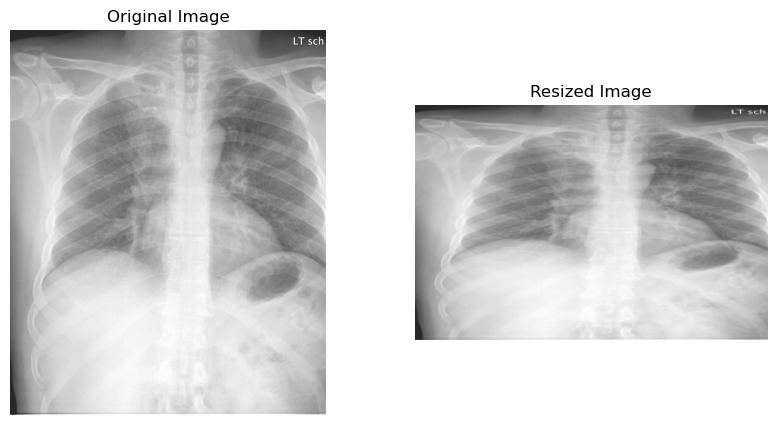

In [53]:
image_path = 'E:/LangsImgDatasetForDiploma/images_normalized/1000_IM-0003-1001.dcm.png'
from PIL import Image
import matplotlib.pyplot as plt

# Open the image

original_image = Image.open(image_path)

# Convert to RGB mode
original_image = original_image.convert('RGB')

# Resize the image to a new width and height
new_width = 300  # Specify your desired width
new_height = 200  # Specify your desired height
resized_image = original_image.resize((new_width, new_height))

# Display the original and resized images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Resized Image')
plt.imshow(resized_image)
plt.axis('off')

plt.show()


(256, 256, 3)


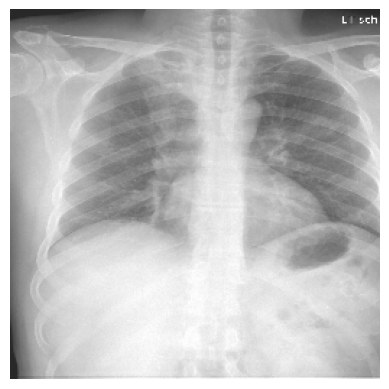

In [52]:
image = image_preprocessing("E:/LangsImgDatasetForDiploma/images_normalized/1000_IM-0003-1001.dcm.png",image_size)
print(image.shape)
display_image(image)

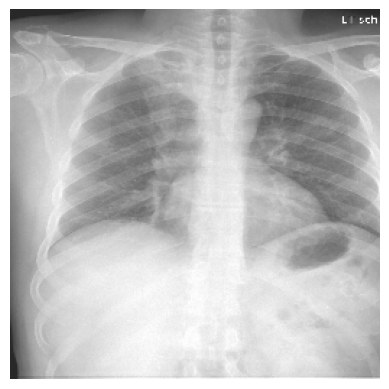

torch.Size([256, 3, 16, 16])


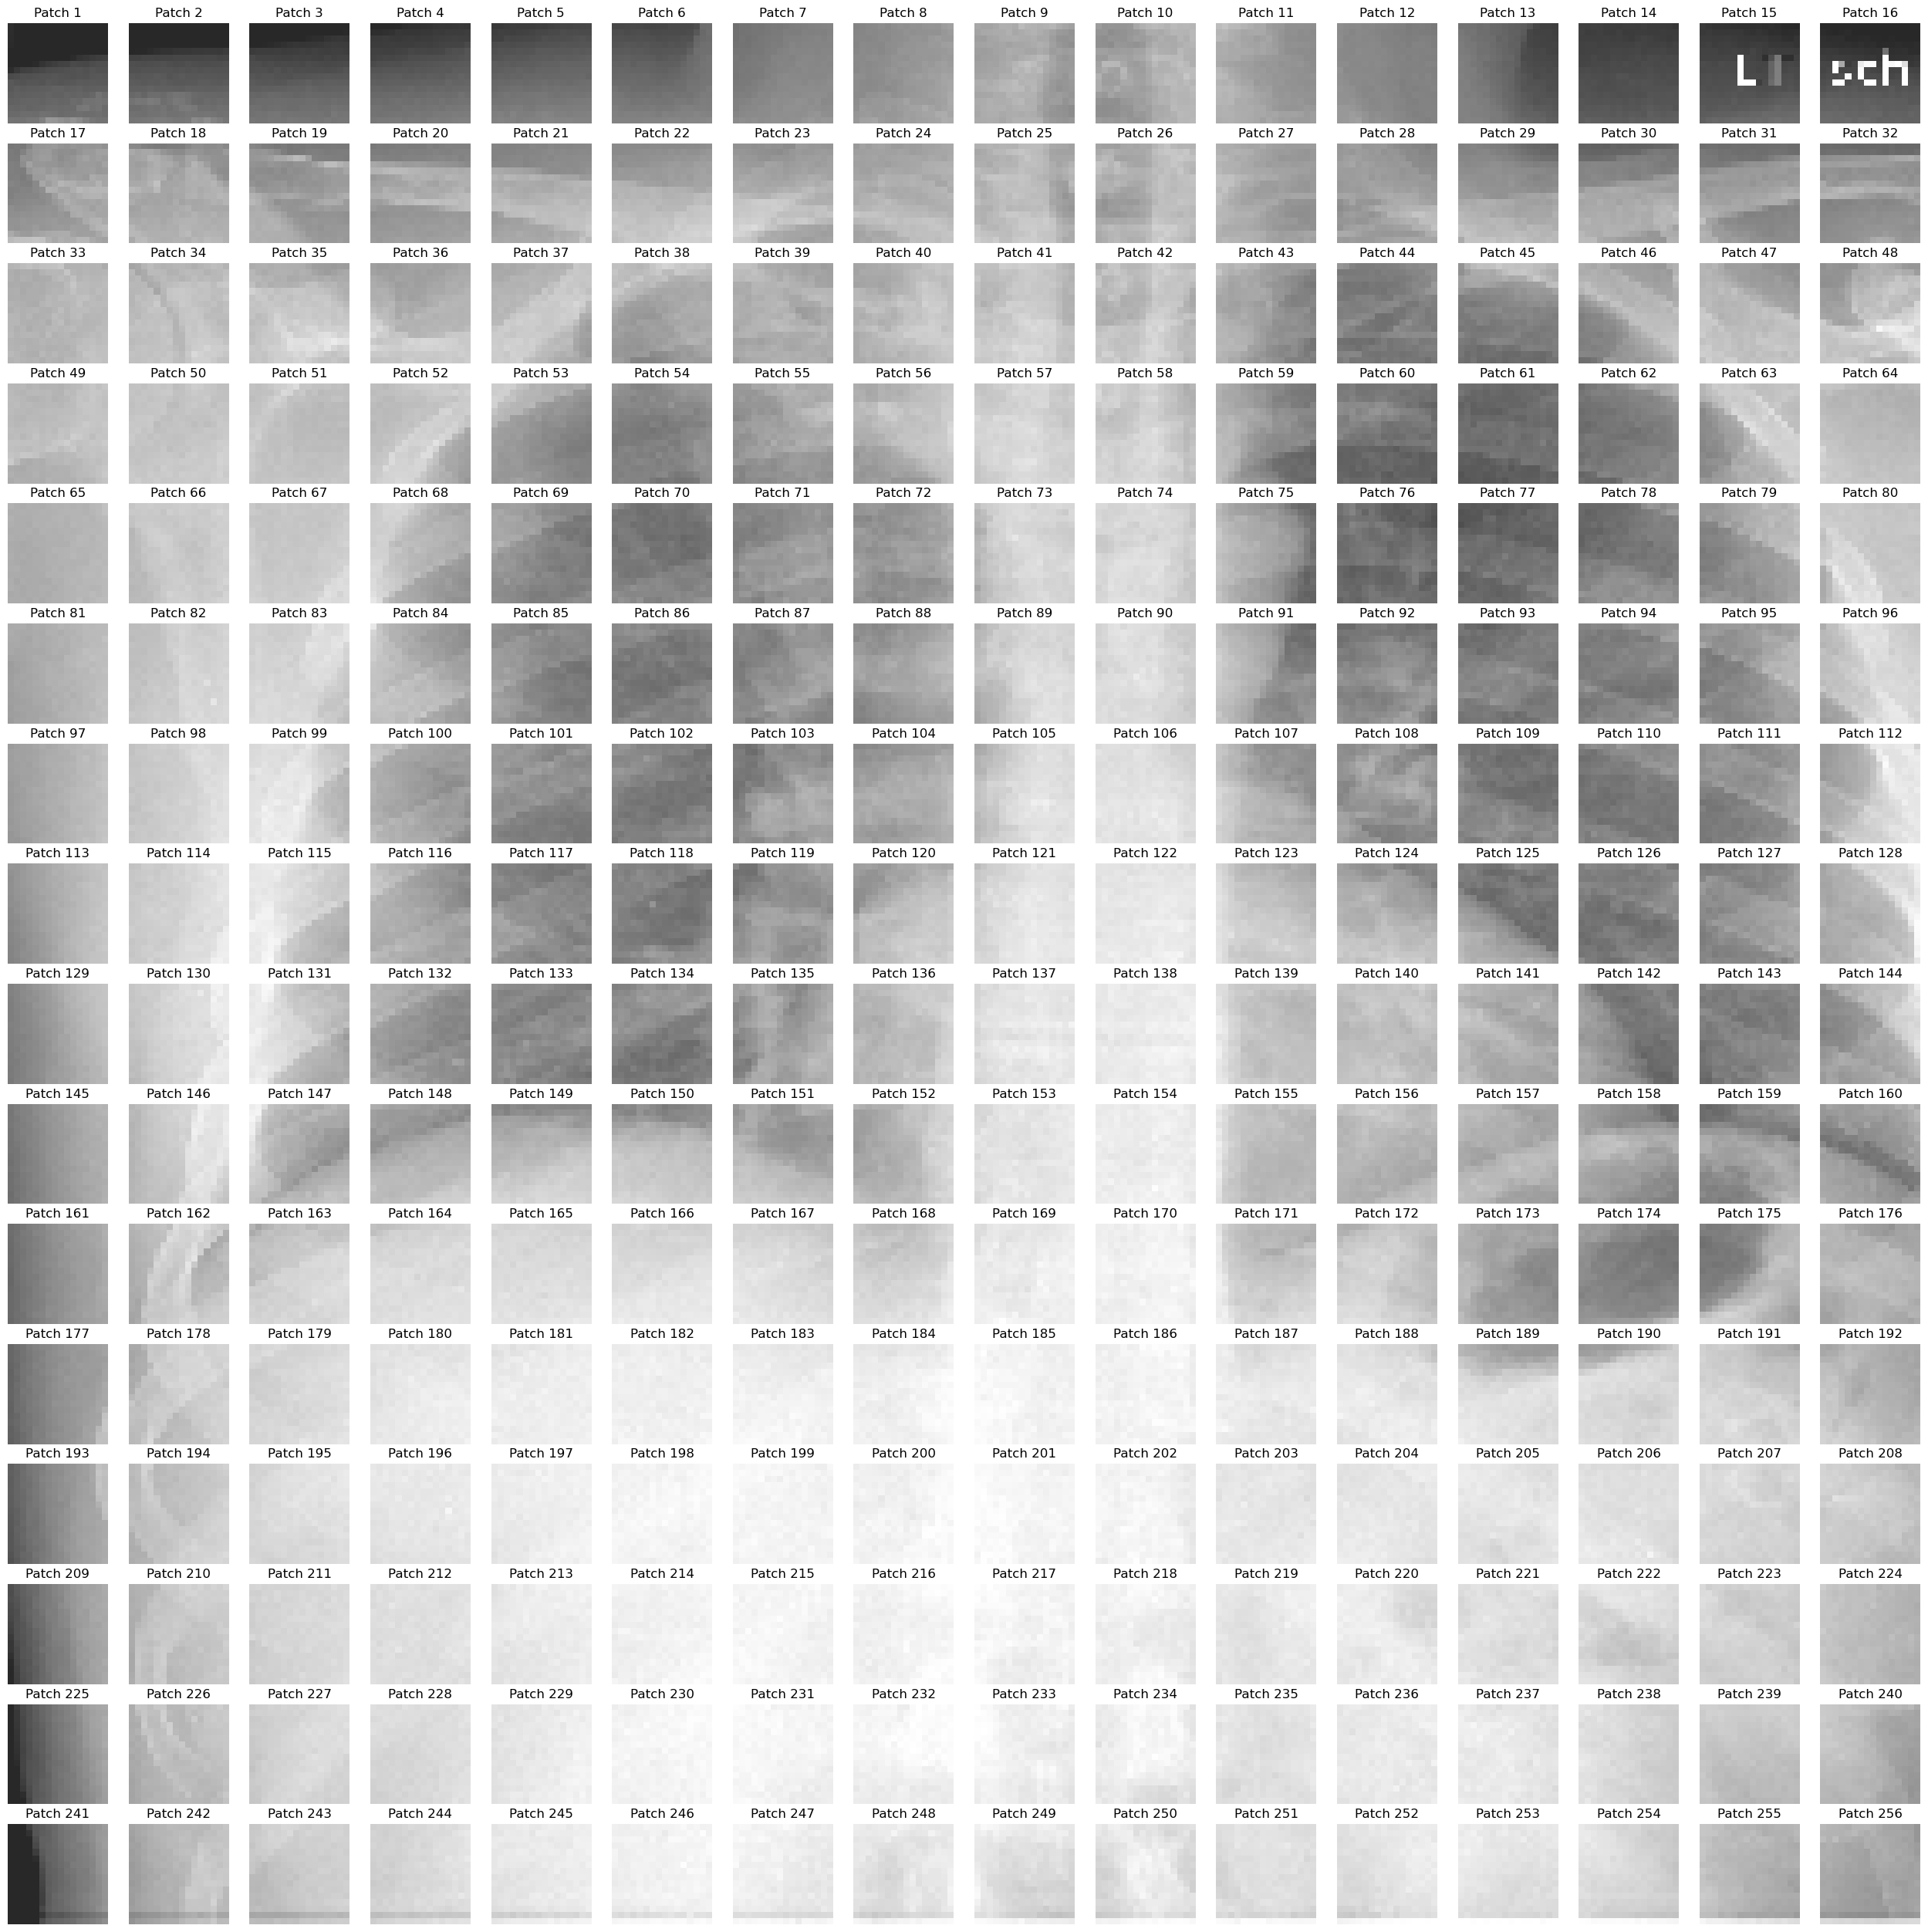

In [54]:
import torch
import matplotlib.pyplot as plt

def create_image_patches(image, patch_size):
    batch_size, channels, height, width = image.size()
    patches = []
    for h in range(0, height, patch_size):
        for w in range(0, width, patch_size):
            patch = image[:, :, h:h+patch_size, w:w+patch_size]
            patches.append(patch)
    patches = torch.cat(patches, dim=0)
    return patches

def plot_patches(patches):
    num_patches = patches.size(0)
    n = int(np.sqrt(num_patches))
    plt.figure(figsize=(2*n, 2*n))
    for i in range(num_patches):
        patch = patches[i].permute(1, 2, 0).numpy()
        plt.subplot(n, n, i + 1)
        plt.imshow(patch)
        plt.title(f"Patch {i+1}")
        plt.axis('off')
    plt.show()

# Example usage
image_size = 256
patch_size = 16

image_array = image_preprocessing("E:/LangsImgDatasetForDiploma/images_normalized/1000_IM-0003-1001.dcm.png", image_size) # shape: (image_size, image_size, 3)
plt.imshow(image_array)
plt.axis('off')  # Turn off axis labels
plt.show()
input_image = torch.tensor(image_array).permute(2,0,1).unsqueeze(0) # shape: (1, 3, image_size, image_size)
input_batch_image = torch.stack([input_image,input_image,input_image,input_image])
patches = create_image_patches(input_image, patch_size)
print(patches.shape)
plot_patches(patches)

In [55]:
def create_batch_patches(input_batch_image):
    batch_patches = []
    for i in range(input_batch_image.shape[0]):
        input_image = input_batch_image[i].unsqueeze(0)
        patches = create_image_patches(input_image, patch_size)
        batch_patches.append(patches)
    return torch.stack(batch_patches, dim=0)

image_array = image_preprocessing("/kaggle/input/chest-xrays-indiana-university/images/images_normalized/1000_IM-0003-2001.dcm.png", image_size) # shape: (image_size, image_size, 3)
input_image = torch.tensor(image_array).permute(2,0,1)
input_batch_image = torch.stack([input_image,input_image,input_image,input_image])
print(input_batch_image.shape)
batch_patches = create_batch_patches(input_batch_image)
print(batch_patches.shape)

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]

        Q = self.query(query)
        K = self.key(key)
        V = self.value(value)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-1, -2)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))

        attention = torch.softmax(scores, dim=-1)
        attended_values = torch.matmul(attention, V)
        attended_values = attended_values.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        output = self.fc_out(attended_values)
        return output, attention

class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, dim_feedforward, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.fc = nn.Sequential(
                                    nn.Linear(d_model, dim_feedforward),
                                    nn.ReLU(),
                                    nn.Linear(dim_feedforward, d_model),
                                )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attended, attention = self.attention(x, x, x, mask)
        x = x + self.dropout1(self.norm1(attended))
        feedforward = self.fc(x)
        x = x + self.dropout2(self.norm2(feedforward))
        return x, attention

class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, d_model, n_heads, image_embedding_size, dim_feedforward, num_layers, dropout=0.1):
        super(VisionTransformer, self).__init__()
        assert image_size % patch_size == 0, "Image dimensions must be divisible by the patch size."
        num_patches = (image_size // patch_size) ** 2
        self.patch_size = patch_size

        self.patch_dim = 3 * patch_size ** 2
        self.patch_embeddings = nn.Linear(self.patch_dim, d_model)
        self.position_embeddings = self.generate_positional_encodings(num_patches + 1, d_model) # nn.Parameter(torch.zeros(1, num_patches + 1, d_model))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.dropout = nn.Dropout(dropout)

        self.transformer_blocks = nn.ModuleList([TransformerBlock(d_model, n_heads, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

        self.fc_head = nn.Linear(d_model, image_embedding_size)
        # self.fc = nn.Linear(image_embedding_size, 10)

    def generate_positional_encodings(self, num_patches, d_model):
        position_encodings = torch.zeros(1, num_patches, d_model)  # Add +1 to num_patches
        position = torch.arange(0, num_patches, dtype=torch.float32).unsqueeze(1)  # Add +1 to num_patches
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        position_encodings[:, :, 0::2] = torch.sin(position * div_term)
        position_encodings[:, :, 1::2] = torch.cos(position * div_term)
        return position_encodings


    def create_image_patches(self, image):
        batch_size, channels, height, width = image.size()
        patches = []
        for h in range(0, height, self.patch_size):
            for w in range(0, width, self.patch_size):
                patch = image[:, :, h:h+self.patch_size, w:w+self.patch_size]
                patches.append(patch)
        patches = torch.cat(patches, dim=0)
        return patches

    def create_batch_patches(self,input_batch_image):
        batch_patches = []
        for i in range(input_batch_image.shape[0]):
            input_image = input_batch_image[i].unsqueeze(0)
            patches = self.create_image_patches(input_image)
            batch_patches.append(patches)
        return torch.stack(batch_patches, dim=0).float()


    def forward(self, x):
        batch_size = x.shape[0]
        x = self.create_batch_patches(x)
        x = x.reshape(x.size(0), x.size(1), x.size(2)*x.size(3)*x.size(4))
        x = self.patch_embeddings(x)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings.to(x.device)
        for transformer in self.transformer_blocks:
            x, _ = transformer(x)

        x = x[:, 0]
        x = self.dropout(x)
        x = self.fc_head(x)
        # x = self.fc(x)
        return x

# Checking ViT using classification data

In [66]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel, AutoTokenizer

# Load pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name) # DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)

def generate_text_embeddings(texts):
    # Tokenize input texts
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)

    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the embeddings from the last hidden layer
    embeddings = outputs.last_hidden_state[:, 0, :] # <---CLS # outputs.last_hidden_state.mean(dim=1)  # You can use other aggregation methods

    return embeddings

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# List of input texts
texts = [ "yo yo CLIP Model", "DistilBERT is a great model for text embedding.", "Vision Transformers for image.", "Contrative Learning" ]

# Generate embeddings
embeddings = generate_text_embeddings(texts)
print("Shape of embeddings:", embeddings.shape)  # Should print (num_texts, embedding_size)

# Model Implementation

In [56]:
import torch
import torch.nn as nn
dropout = 0.1
class ImageProjection(nn.Module):
    def __init__(self, image_embedding_size, shared_embedding_size):
        super(ImageProjection, self).__init__()
        self.image_projection = nn.Linear(image_embedding_size, shared_embedding_size)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(shared_embedding_size, shared_embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(shared_embedding_size)

    def forward(self, image_embeddings):
        projected_embeddings = self.image_projection(image_embeddings)

        x = self.gelu(projected_embeddings)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected_embeddings
        x = self.layer_norm(x)

        return x # projected_embeddings

class TextProjection(nn.Module):
    def __init__(self, text_embedding_size, shared_embedding_size):
        super(TextProjection, self).__init__()
        self.text_projection = nn.Linear(text_embedding_size, shared_embedding_size)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(shared_embedding_size, shared_embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(shared_embedding_size)

    def forward(self, text_embeddings):
        projected_embeddings = self.text_projection(text_embeddings)

        x = self.gelu(projected_embeddings)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected_embeddings
        x = self.layer_norm(x)

        return x # projected_embeddings

"""
class CosineSimilarity(nn.Module):
    def __init__(self, temperature = 0.2 ):
        super(CosineSimilarity, self).__init__()
        self.temperature = temperature

    def forward(self, image_embeddings, text_embeddings):
        normalized_images = nn.functional.normalize(image_embeddings, dim=-1)
        normalized_texts = nn.functional.normalize(text_embeddings, dim=-1)

        similarities = torch.matmul(normalized_images, normalized_texts.t())*self.temperature
        return similarities
"""

'\nclass CosineSimilarity(nn.Module):\n    def __init__(self, temperature = 0.2 ):\n        super(CosineSimilarity, self).__init__()\n        self.temperature = temperature\n\n    def forward(self, image_embeddings, text_embeddings):\n        normalized_images = nn.functional.normalize(image_embeddings, dim=-1)\n        normalized_texts = nn.functional.normalize(text_embeddings, dim=-1)\n\n        similarities = torch.matmul(normalized_images, normalized_texts.t())*self.temperature\n        return similarities\n'

In [57]:
def count_trainable_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return trainable_params

In [67]:
count_trainable_parameters(model)

66362880

batch_idx:  0  Image Shape:  torch.Size([3, 256, 256]) Text Count:  4


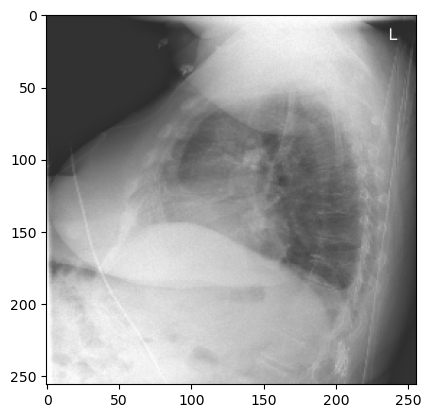

The cardiomediastinal silhouette and vasculature are within normal limits for size and contour. The lungs are normally inflated and clear. Osseous structures are within normal limits for patient age.


In [74]:
import os

# Set the environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "true"

# Checking Data Setup
for batch_idx, (texts, images, labels) in enumerate(train_dataloader):
    print( "batch_idx: ", batch_idx, " Image Shape: ", images[0].shape, "Text Count: ", len(texts) )
    plt.imshow( torch.moveaxis( images[0], 0, 2 ).numpy() )
    plt.show()
    print(texts[0])
    break

# Loss Function

In [60]:
dropout = 0.1

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

temperature_value = 1

def contrastive_clip_loss_function( text_projection,  image_projection, mode="eval" ):
    logits = (text_projection @ image_projection.T) / temperature_value
    if mode=="train":
        images_similarity = image_projection @ image_projection.T
        texts_similarity = text_projection @ text_projection.T
        targets = F.softmax( (images_similarity + texts_similarity) / 2 * temperature_value, dim=-1 )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()
    elif mode=="eval":
        return logits
    else:
        print("Mention mode")
        return None

# Previous Model Setups

In [61]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import time

# Training Model - ResNet50 + Distil BERT

In [ ]:

#   - - - - - - - - - - - - - - - - - -   Hyperparameters    - - - - - - - - - - - - - - - - - -
shared_embedding_size = 512  # d_e shared embedding space
learning_rate = 5e-4

#  - - - - - - - - - - - - - - - - - -   Create model components   - - - - - - - - - - - - - - - - - -
# - - - - - - - - - ResNet Model - - - - - - - - -
# Load a pre-trained ResNet model
image_embedding_size=1024*2
resnet_model = models.resnet50(pretrained=True)
# Remove the classification layer (the last fully connected layer)
resnet_model = nn.Sequential( *list(resnet_model.children())[:-1] )
resnet_model.to(device)
print(" Number of Trainable Parameters in", " ResNet50 Model :  ",   count_trainable_parameters(resnet_model))

# - - - - - - - - -  Distil BERT Model  - - - - - - - - -
max_length = 32
text_embedding_size = 768  # d_i

# Load pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
text_tokenizer = DistilBertTokenizer.from_pretrained(model_name) # .to(device)
text_model = DistilBertModel.from_pretrained(model_name ).to(device)
print(" Number of Trainable Parameters in", " DistilBERT model :  ",   count_trainable_parameters(text_model))


# - - - - - - - - -  Projections  - - - - - - - - -
image_projector = ImageProjection(image_embedding_size, shared_embedding_size).to(device)
print(" Number of Trainable Parameters in", " Image Projection :  ",   count_trainable_parameters(image_projector))
text_projector = TextProjection(text_embedding_size, shared_embedding_size).to(device)
print(" Number of Trainable Parameters in", " Text Projection :  ",   count_trainable_parameters(text_projector))
print("\n - - - - - - - - - - \n \n  Training......  ")

# - - - - - - - - -  Loss  - - - - - - - - -
# sym_loss_fn = SymmetricalLoss(margin=0.1).to(device)
# contrastive_loss = ContrastiveLoss(temperature=0.9)

# - - - - - - - - -  Optimizer  - - - - - - - - -
# optimizer = optim.AdamW( list(resnet_model.parameters()) + list(text_model.parameters()) + list(image_projector.parameters()) + list(text_projector.parameters()), lr=learning_rate )
params = [{"params":resnet_model.parameters(), "lr":1e-4 }, {"params":text_model.parameters(), "lr":1e-5},
          # {"params":image_projector.parameters(), "lr": }, {"params":text_projector.parameters(), "lr":}
          {"params": itertools.chain( image_projector.parameters(), text_projector.parameters() ), "lr":1e-3 , "weight_decay":1e-3 }
         ]
optimizer = optim.AdamW( params,  weight_decay=0. )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( optimizer, mode="min", patience=2 , factor=0.8 )

# - - - - - - - - -  Training loop  - - - - - - - - -
for epoch in range(num_epochs):
    # Record the start time
    start_time = time.time()
    print( " - - - - - - - - - - - Epoch:", epoch+1, " - - - - - - - - - - - - "  )
    resnet_model.train()
    text_model.train()
    image_projector.train()
    text_projector.train()
    total_loss = 0.0

    for batch_idx, (images, texts) in enumerate(train_dataloader):
        # - - - - - - - - -  Forward pass  - - - - - - - - -
        optimizer.zero_grad()

        # - - - -  Text  - - - -
        inputs = tokenizer(texts, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state[:, 0, :] # outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)

        # - - - -  Image  - - - -
        images = images.to(device)
        # images = preprocess_images(images)
        image_embeddings = resnet_model(images)
        image_projection = image_projector(image_embeddings[:,:,0,0])

        # - - - -  Compute Loss  - - - -
        # loss = sym_loss_fn(image_projection, text_projection)
        # loss = contrastive_loss(image_projection, text_projection)
        loss = contrastive_clip_loss_function( text_projection,  image_projection, mode="train")

        # - - - -  Backpropagation  - - - -
        loss.backward()
        optimizer.step()

        # - - - - Loss print - - - -
        total_loss += loss.item()
        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], Loss: {total_loss/((batch_idx+1)*batch_size):.4f}")


    lr_scheduler.step(total_loss)

    # Record the end time
    end_time = time.time()
    elapsed_time = end_time - start_time
    # - - - - Loss each epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}", "  Time Taken: ", elapsed_time, " seconds" )

In [62]:
resnet_model.eval()
image_projector.eval()

def create_image_embeddings(images):
    with torch.no_grad():
        image_embeddings = resnet_model(images)
        image_projection = image_projector(image_embeddings[:,:,0,0])
    return image_projection

image_embeddings_list_train = []

for index in tqdm(range(len( train_dataset ))):
    images = train_dataset[index][0]
    images = images.to(device)
    image_projection = create_image_embeddings(images.unsqueeze(0))
    image_embeddings_list_train.append( image_projection[0] )


def image_retrieval_function( input_query, n , display=False): # n --> number of images
    with torch.no_grad():
        inputs = tokenizer(input_query, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)

    similarity_scores_list = []
    for index in tqdm(range(len(image_embeddings_list_train))):
        score = torch.dot( text_projection[0], image_embeddings_list_train[index] )
        similarity_scores_list.append( score.cpu().numpy() )

    max_indexes = np.array(similarity_scores_list).argsort()[-n:][::-1]
    if display:
        for index in max_indexes:
            image_tensor = train_dataset[index][0]
            plt.imshow( torch.moveaxis(image_tensor, 0,2) )
            plt.show()
        return None
    else:
        return max_indexes

NameError: name 'resnet_model' is not defined

In [ ]:
input_query = "silhouette"
image_retrieval_function( input_query, n=10, display=True )

In [ ]:
input_query = "man"
image_retrieval_function( input_query, n=3, display=True )

In [ ]:
input_query = "women"
image_retrieval_function( input_query, n=5, display=True )

In [ ]:
input_query = "bike on the road"
image_retrieval_function( input_query, n=2, display=True )

# Training Model - ViT + Distil BERT

In [63]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#   - - - - - - - - - - - - - - - - - -   Hyperparameters    - - - - - - - - - - - - - - - - - -
shared_embedding_size = 512  # d_e shared embedding space

#  - - - - - - - - - - - - - - - - - -   Create model components   - - - - - - - - - - - - - - - - - -
# - - - - - - - - - ViT Model - - - - - - - - -
image_size = 256
patch_size = 16
d_model = 512*4
n_heads = 8
dim_feedforward = 2048
num_layers = 12
image_embedding_size=1024  # d_i

ViT_model = VisionTransformer(image_size, patch_size, d_model, n_heads, image_embedding_size, dim_feedforward, num_layers).to(device)
print(" Number of Trainable Parameters in", " ViT model :  ",   count_trainable_parameters(ViT_model))

# - - - - - - - - -  Distil BERT Model  - - - - - - - - -
max_length = 32
text_embedding_size = 768  # d_i

# Load pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
text_tokenizer = DistilBertTokenizer.from_pretrained(model_name) # .to(device)
text_model = DistilBertModel.from_pretrained(model_name ).to(device)
print(" Number of Trainable Parameters in", " DistilBERT model :  ",   count_trainable_parameters(text_model))


# - - - - - - - - -  Projections  - - - - - - - - -
image_projector = ImageProjection(image_embedding_size, shared_embedding_size).to(device)
print(" Number of Trainable Parameters in", " Image Projection :  ",   count_trainable_parameters(image_projector))
text_projector = TextProjection(text_embedding_size, shared_embedding_size).to(device)
print(" Number of Trainable Parameters in", " Text Projection :  ",   count_trainable_parameters(text_projector))
print("\n - - - - - - - - - - \n \n  Training......  ")

# - - - - - - - - -  Loss  - - - - - - - - -
# sym_loss_fn = SymmetricalLoss(margin=0.1).to(device)
# contrastive_loss = ContrastiveLoss(temperature=0.9)

# - - - - - - - - -  Optimizer  - - - - - - - - -
# optimizer = optim.AdamW( list(ViT_model.parameters())+ list(text_model.parameters()) + list(image_projector.parameters()) + list(text_projector.parameters()), lr=learning_rate )
params = [{"params":ViT_model.parameters(), "lr":1e-3 }, {"params":text_model.parameters(), "lr":1e-4},
          # {"params":image_projector.parameters(), "lr": }, {"params":text_projector.parameters(), "lr":}
          {"params": itertools.chain( image_projector.parameters(), text_projector.parameters() ), "lr":1e-3 , "weight_decay":1e-3 }
         ]
optimizer = optim.AdamW( params,  weight_decay=0.0 )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( optimizer, mode="min", patience=1 , factor=0.8 )

# import torch.optim.lr_scheduler as lr_scheduler
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # step_size=step_size
# warmup_epochs = 25  # Number of epochs for warm-up

# - - - - - - - - -  Training loop  - - - - - - - - -
for epoch in range(num_epochs):
    print( " - - - - - - - - - - - Epoch:", epoch+1, " - - - - - - - - - - - - "  )
    ViT_model.train()
    text_model.train()
    image_projector.train()
    text_projector.train()
    total_loss = 0.0

    for batch_idx, (images, texts) in enumerate(train_dataloader):
        # - - - - - - - - -  Forward pass  - - - - - - - - -
        optimizer.zero_grad()

        # - - - -  Text  - - - -
        inputs = tokenizer(texts, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state[:, 0, :] # outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)

        # - - - -  Image  - - - -
        images = images.to(device)
        image_embeddings = ViT_model(images)
        image_projection = image_projector(image_embeddings)

        # - - - -  Compute Loss  - - - -
        # loss = sym_loss_fn(image_projection, text_projection)
        # loss = contrastive_loss(image_projection, text_projection)
        loss = contrastive_clip_loss_function( text_projection,  image_projection, mode="train")

        # - - - -  Backpropagation  - - - -
        loss.backward()
        optimizer.step()

#     if epoch < warmup_epochs:
#         scheduler.step(epoch)
#     else:
#         scheduler.step()

        # - - - - Loss print - - - -
        total_loss += loss.item()

        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], Loss: {total_loss/((batch_idx+1)*batch_size):.4f}")


    # - - - - Loss each epoch
    avg_loss = total_loss / len(train_dataloader)
    lr_scheduler.step(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

In [ ]:
"""
# 11891904 + 22155456 + 66362880 + 105987072

try:
    checkpoint = {
        'ViT_model_dict': ViT_model.state_dict(),
        # 'resnet_model_dict': resnet_model.state_dict(),
        'text_model_dict': text_model.state_dict(),
        'image_projector_dict': image_projector.state_dict(),
        'text_projector_dict': text_projector.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, "/kaggle/working/CLIP_model_from_Scratch_ResNet_DistilBERT")

except:
    print("Error in some saving")

"""

# Inference | Image Retrieval | ViT Setup

In [ ]:
ViT_model.eval()
image_projector.eval()

def create_image_embeddings(images):
    with torch.no_grad():
        image_embeddings = ViT_model(images)
        image_projection = image_projector(image_embeddings)
    return image_projection

image_embeddings_list_train = []

for index in tqdm(range(len( train_dataset ))):
    images = train_dataset[index][0]
    images = images.to(device)
    image_projection = create_image_embeddings(images.unsqueeze(0))
    image_embeddings_list_train.append( image_projection[0] )


def image_retrieval_function( input_query, n , display=False): # n --> number of images
    with torch.no_grad():
        inputs = tokenizer(input_query, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)

    similarity_scores_list = []
    for index in tqdm(range(len(image_embeddings_list_train))):
        score = torch.dot( text_projection[0], image_embeddings_list_train[index] )
        similarity_scores_list.append( score.cpu().numpy() )

    max_indexes = np.array(similarity_scores_list).argsort()[-n:][::-1]
    if display:
        for index in max_indexes:
            image_tensor = train_dataset[index][0]
            plt.imshow( torch.moveaxis(image_tensor, 0,2) )
            plt.show()
        return None
    else:
        return max_indexes

In [ ]:
input_query = "dog"
image_retrieval_function( input_query, n=3, display=True )

In [ ]:
input_query = "man"
image_retrieval_function( input_query, n=3, display=True )

In [ ]:
input_query = "women"
image_retrieval_function( input_query, n=5, display=True )

In [ ]:
input_query = "bike on the road"
image_retrieval_function( input_query, n=5, display=True )

# Evaluation | Testing

In [ ]:
accuracy_counter = 0

# ViT_model.eval()
resnet_model.eval()
text_model.eval()
image_projector.eval()
text_projector.eval()

# cosine_similarity = CosineSimilarity(temperature=temperature_value)

with torch.no_grad():
    for batch_images, batch_captions in tqdm(train_dataloader):
        batch_size = batch_images.size(0)

        # - - - - - - - - -  Forward pass  - - - - - - - - -
        # - - - -  Text  - - - -
        inputs = tokenizer(batch_captions, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)

        # - - - -  Image  - - - -
        batch_images = batch_images.to(device)
#         image_embeddings = ViT_model(batch_images)
#         image_projection = image_projector(image_embeddings)
        image_embeddings = resnet_model(batch_images)
        image_projection = image_projector(image_embeddings[:,:,0,0])

        # Calculate cosine similarities
        for index_text in range(batch_size):
            similarity_scores_list = []
            for index_image in range(len(image_projection)):
                score = torch.dot( text_projection[index_text], image_projection[index_image] )
                similarity_scores_list.append( score.cpu().numpy() )
            similarity_scores_list = np.array(similarity_scores_list)

            max_index = np.argmax(similarity_scores_list)
            if max_index==index_text:
                accuracy_counter += 1

#         # Convert indices to captions for comparison
#         batch_pred_captions = [batch_captions[index] for index in batch_pred_indices]
#         batch_actual_captions = batch_captions

#         # Calculate accuracy
#         for pred_caption, actual_caption in zip(batch_pred_captions, batch_actual_captions):
#             if pred_caption == actual_caption:
#                 accuracy_counter += 1

total_samples = len(train_dataloader.dataset)
accuracy = accuracy_counter / total_samples
print(f"Accuracy (Pencentage of Correct Matching): {accuracy*100:.4f}")

In [ ]:
accuracy_counter = 0

# ViT_model.eval()
resnet_model.eval()
text_model.eval()
image_projector.eval()
text_projector.eval()

# cosine_similarity = CosineSimilarity(temperature=temperature_value)

with torch.no_grad():
    for batch_images, batch_captions in tqdm(test_dataloader):
        batch_size = batch_images.size(0)

        # - - - - - - - - -  Forward pass  - - - - - - - - -
        # - - - -  Text  - - - -
        inputs = tokenizer(batch_captions, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)

        # - - - -  Image  - - - -
        batch_images = batch_images.to(device)
        image_embeddings = resnet_model(batch_images)
        image_projection = image_projector(image_embeddings[:,:,0,0])

        # Calculate cosine similarities
        for index_text in range(batch_size):
            similarity_scores_list = []
            for index_image in range(len(image_projection)):
                score = torch.dot( text_projection[index_text], image_projection[index_image] )
                similarity_scores_list.append( score.cpu().numpy() )
            similarity_scores_list = np.array(similarity_scores_list)

            max_index = np.argmax(similarity_scores_list)
            if max_index==index_text:
                accuracy_counter += 1

total_samples = len(test_dataloader.dataset)
accuracy = accuracy_counter / total_samples
print(f"Accuracy (Pencentage of Correct Matching): {accuracy*100:.4f}")

# References:

Image Reference: https://www.youtube.com/watch?v=GLa7z5rkSf4

Paper: https://arxiv.org/abs/2103.00020

Website: https://openai.com/research/clip

Vision Transformer Model (ViT) : https://arxiv.org/pdf/2010.11929v2.pdf  |  https://huggingface.co/docs/transformers/main/model_doc/vit